# Project 6 - Nematode status assay

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, segmentation, feature
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image

# Correct loading

[[86 92 97 ... 91 92 89]
 [87 92 92 ... 91 86 93]
 [88 90 91 ... 90 91 90]
 ...
 [92 91 94 ... 95 94 95]
 [89 94 93 ... 96 94 92]
 [96 93 87 ... 96 92 92]] 2765


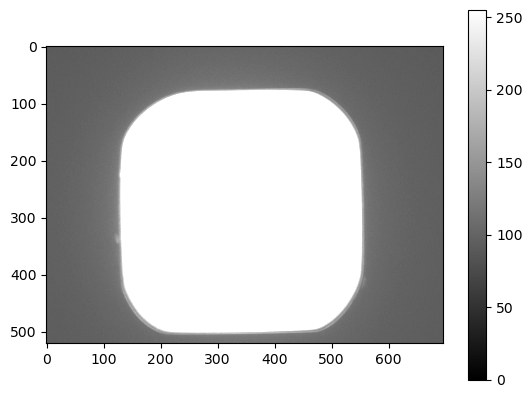

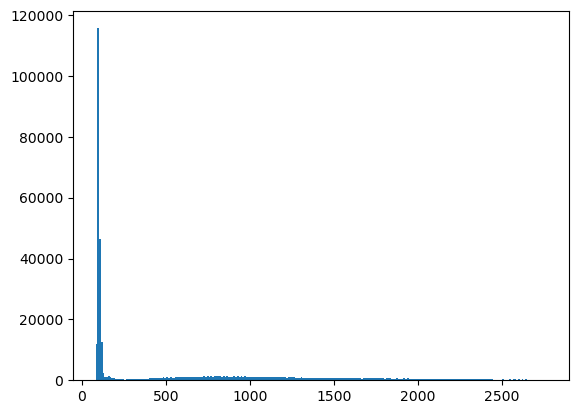

In [11]:
test = Image.open('Data/1649_1109_0003_Amp5-1_B_20070424_A13_w2_F3700E53-0F0F-4721-99FC-B14F70D3CD53.tif')
test_pixels = np.asarray(test)
print(test_pixels, np.max(test_pixels))
plt.imshow(test_pixels, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(test_pixels.flatten(), bins = 255)
plt.show()

In [12]:
def stretch(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (255*((img-mini)/(maxi-mini)))

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [1 1 0 ... 1 0 0]]


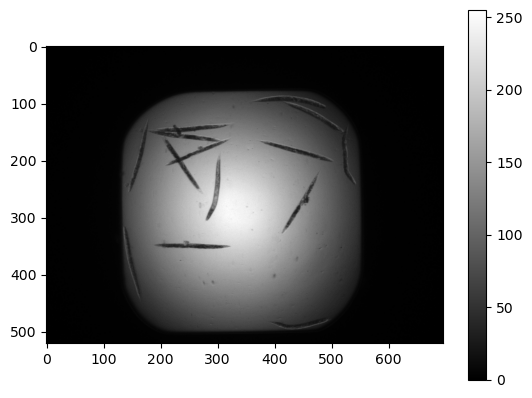

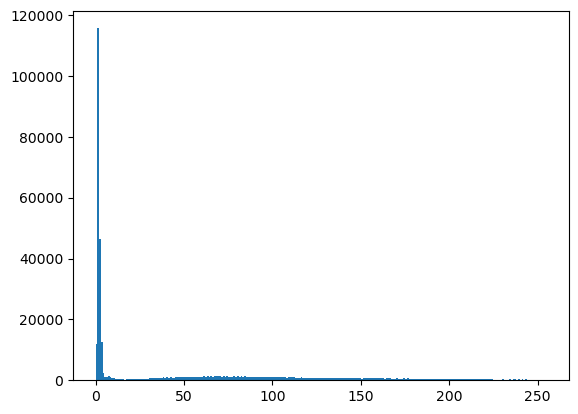

In [13]:
stretch_test_pixel = stretch(test_pixels).astype(int)
print(stretch_test_pixel)

plt.imshow(stretch_test_pixel, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(stretch_test_pixel.flatten(), bins = 255)
plt.show()

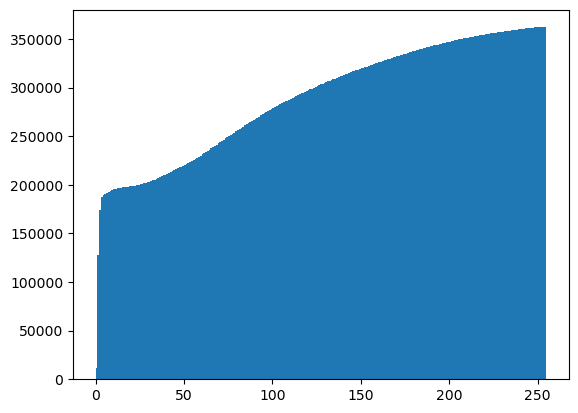

In [14]:
plt.hist(stretch_test_pixel.flatten(), bins = 255, cumulative='T')
plt.show()

# Quality verification

# Segmentation

## Window extraction

In [15]:
window_threshold = 8

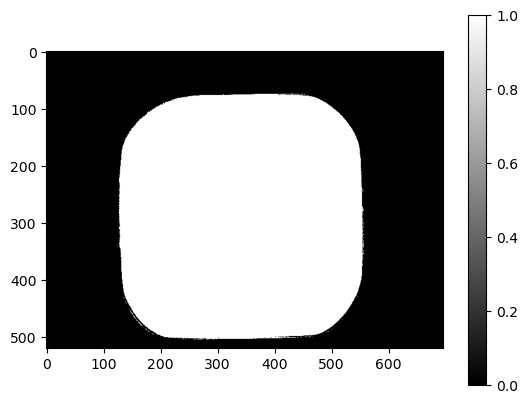

In [16]:
empty_window = stretch_test_pixel>window_threshold
plt.imshow(empty_window, cmap="gray", vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

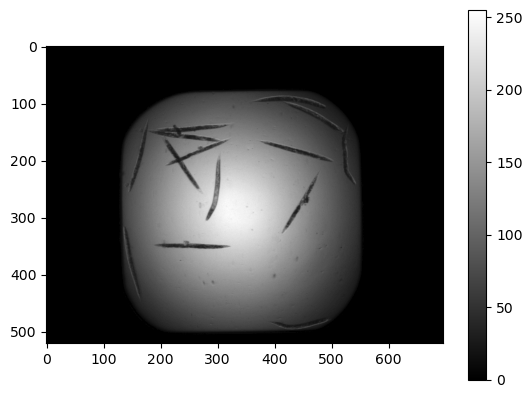

In [17]:
window = empty_window*stretch_test_pixel
plt.imshow(window, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

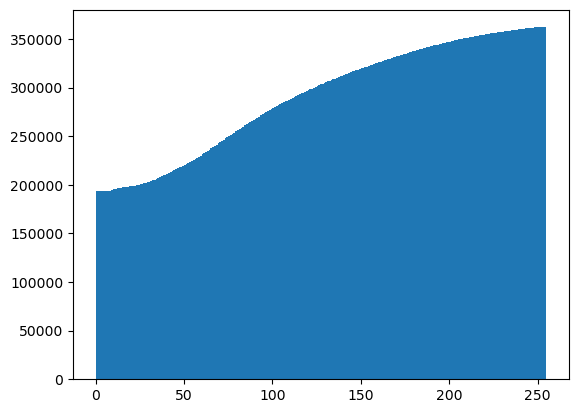

In [18]:
plt.hist(window.flatten(), bins = 255, cumulative='T')
plt.show()